In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.base.datetools import dates_from_str
from sklearn.metrics import mean_squared_error

def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    
    return diff

def plot_graph(title, data, color, name):
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(data, color=color)


 
    ax.grid(True, 'major', linewidth=0.34)
    spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

    for spine in spines: 
        spine.set_visible(False)

    plt.title(title, fontweight=500, fontsize=22)

    plt.savefig(name)

In [2]:
df_zillow = pd.read_csv('data/zillow-california.csv', index_col='Date')
df_zillow = df_zillow[~df_zillow['MedianSoldPrice_AllHomes.California'].isnull()]
df_zillow.index = dates_from_str(df_zillow.index)

In [3]:
df_zillow.shape

(95, 3)

In [4]:
df_zillow.columns

Index(['MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')

In [5]:
df_zillow.tail()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0
2015-11-30,485750.0,3.69,5.0
2015-12-31,485000.0,3.89,5.1


In [6]:
X = df_zillow[['MedianMortageRate', 'UnemploymentRate']]
y = df_zillow[['MedianSoldPrice_AllHomes.California']]

In [7]:
X_train = X.loc[:'11-30-2014']
y_train = y.loc[:'11-30-2014']
X_valid = X.loc['12-01-2014':'11-30-2015']
y_valid = y.loc['12-01-2014':'11-30-2015']

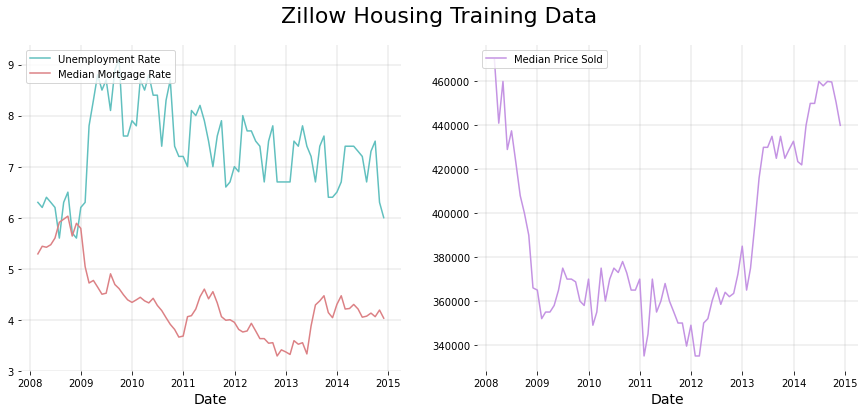

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(X_train['UnemploymentRate'], label='Unemployment Rate', color='#61c0bf')
axes[0].plot(X_train['MedianMortageRate'], label="Median Mortgage Rate", color='#DC8185')
axes[1].plot(y_train, label="Median Price Sold", color='#C493E3')

for ax in axes:
    ax.grid(True, 'major', linewidth=0.34)
    ax.legend(loc='upper left')
 
    ax.set_xlabel("Date", fontweight=530, fontsize=14)
#ax.set_ylabel("Beer Drunk (Liters)", fontweight=530, fontsize=13)
    spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

    for spine in spines: 
        spine.set_visible(False)

plt.title("Zillow Housing Training Data", fontweight=500, fontsize=22, x=-0.1, y=1.05)

plt.savefig('results/Zillow Housing EDA')

# Unemployment Rate: 

- Somewhat quadratic? Difference twice to detrend and see what happens
- Seasonality: 1 year cycles (m=12)

In [9]:
UnempDiff1 = diff(X_train['UnemploymentRate'], 1)

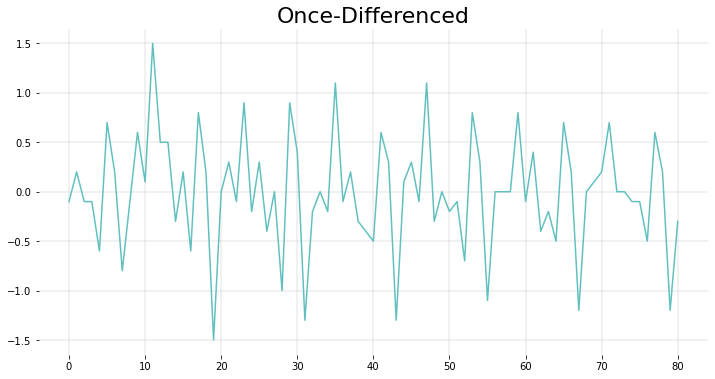

In [10]:
plot_graph("Once-Differenced", UnempDiff1, '#61c0bf', 'results/Unemployment-1D.png')

In [11]:
dftest = adfuller(UnempDiff1, autolag='BIC')
UnemploymentTest = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
UnemploymentTest

Test Statistic   -1.566814
p-value           0.500239
dtype: float64

In [12]:
UnempDiff2 = diff(UnempDiff1, 1)

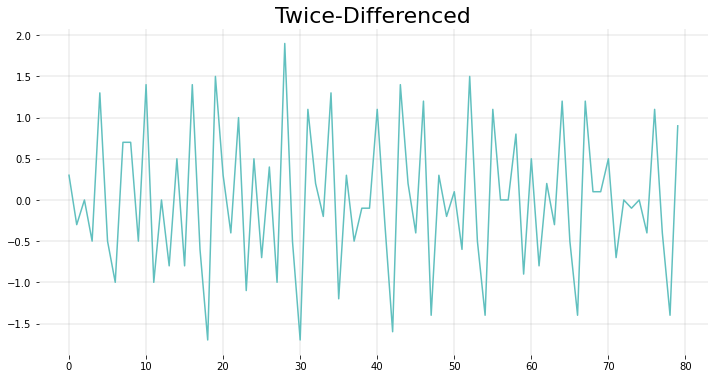

In [13]:
plot_graph("Twice-Differenced", UnempDiff2, '#61c0bf',  'results/Unemployment-2D.png')

In [14]:
dftest = adfuller(UnempDiff2, autolag='BIC')
UnemploymentTest = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
UnemploymentTest

Test Statistic   -1.436825e+01
p-value           9.590671e-27
dtype: float64

# Median Mortgage Rate
- Linear, difference once
- Around a two year seasonality: m=24

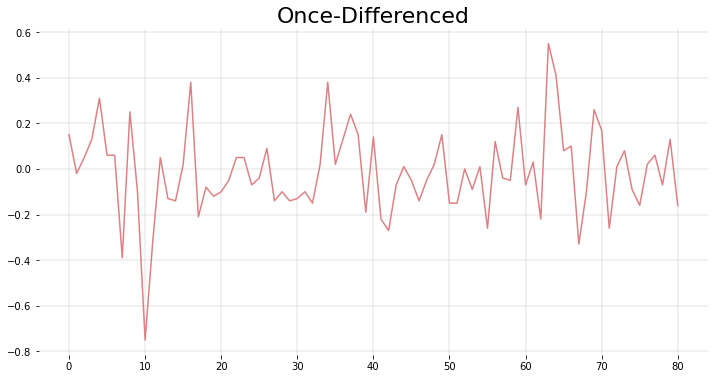

In [17]:
MortRateDiff1 = diff(X_train['MedianMortageRate'], 1)
plot_graph('Once-Differenced', MortRateDiff1, '#DC8185', 'results/Median-Mortgage-1D.png')

In [18]:
dftest = adfuller(MortRateDiff1, autolag='BIC')
MortRateTest = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
MortRateTest

Test Statistic   -7.895040e+00
p-value           4.333583e-12
dtype: float64

# Median Price Sold

- Also shows quadratic nature: difference twice

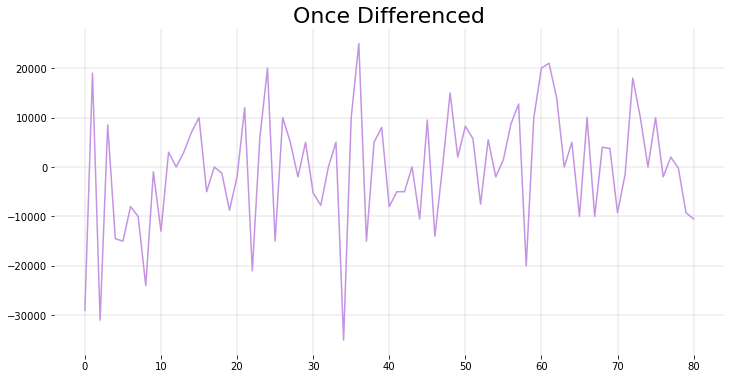

In [21]:
MedPriceDiff1 = diff(y_train['MedianSoldPrice_AllHomes.California'], 1)
plot_graph('Once Differenced', MedPriceDiff1, '#C493E3', 'results/Median-Price-1D.png')

In [22]:
dftest = adfuller(MedPriceDiff1, autolag='BIC')
MedPriceTest = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
MedPriceTest

Test Statistic   -1.080568e+01
p-value           1.966155e-19
dtype: float64

# EDA Conclusion:

-since Unemployment Rate needs to be twice differenced to become stationary, all other columns will follow suit

In [23]:
# MedPrice_Col2 = diff(MedPrice_Col, 1)
# MortRate_Col2 = diff(MortRate_Col, 1)
# zillow_diff = pd.DataFrame({'UnemploymentRate': Unemployment_Col,
#                             'MedianMortgageRate': MortRate_Col2,
#                             'MedianPriceSold': MedPrice_Col2
#                            })
# zillow_diff

zillow_diff = df_zillow.diff().dropna()
zillow_diff = zillow_diff.diff().dropna()
zillow_diff_train = zillow_diff.loc[:'11-30-2014']
zillow_diff_test  = zillow_diff.loc['12-1-2014':]

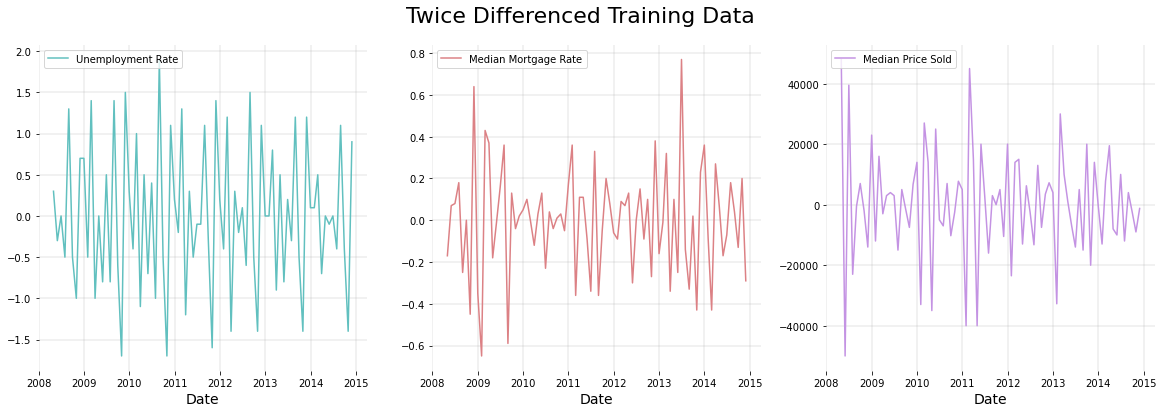

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].plot(zillow_diff_train['UnemploymentRate'], label='Unemployment Rate', color='#61c0bf')
axes[1].plot(zillow_diff_train['MedianMortageRate'], label="Median Mortgage Rate", color='#DC8185')
axes[2].plot(zillow_diff_train['MedianSoldPrice_AllHomes.California'], label="Median Price Sold", color='#C493E3')

for ax in axes:
    ax.grid(True, 'major', linewidth=0.34)
    ax.legend(loc='upper left')
 
    ax.set_xlabel("Date", fontweight=530, fontsize=14)
#ax.set_ylabel("Beer Drunk (Liters)", fontweight=530, fontsize=13)
    spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

    for spine in spines: 
        spine.set_visible(False)

plt.title("Twice Differenced Training Data", fontweight=500, fontsize=22, x=-.75, y=1.05)

plt.savefig('results/Zillow-Housing-2D-EDA.png')

- Everything is now stationary
- Let's normalize so that all columns are between 0 and 1
    - Doing so because we are using a regression function which is sensitive to scale

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler.fit_transform(zillow_diff_train)
zillow_diff_scaled = pd.DataFrame(scaled_input)
cols = zillow_diff_train.columns
zillow_diff_scaled.rename(columns = {0:cols[0], 1:cols[1], 2:cols[2]}, inplace=True)
zillow_diff_scaled.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,1.000000,0.338028,0.555556
1,0.000000,0.507042,0.388889
2,0.913265,0.514085,0.472222
3,0.275510,0.584507,0.333333
4,0.505102,0.281690,0.833333


In [26]:
df_zillow = df_zillow.rename(columns={"MedianSoldPrice_AllHomes.California":"MedianPriceSold",
                                      "MedianMortageRate":"MedianMortgageRate"
})
zillow_diff_scaled = zillow_diff_scaled.rename(columns={"MedianSoldPrice_AllHomes.California":"MedianPriceSold",
                                      "MedianMortageRate":"MedianMortgageRate"
})

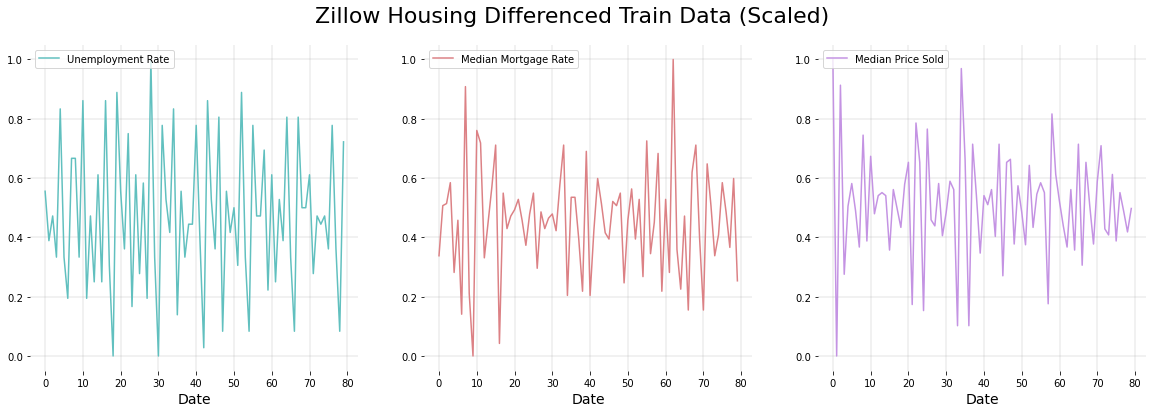

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].plot(zillow_diff_scaled['UnemploymentRate'], label='Unemployment Rate', color='#61c0bf')
axes[1].plot(zillow_diff_scaled['MedianMortgageRate'], label="Median Mortgage Rate", color='#DC8185')
axes[2].plot(zillow_diff_scaled['MedianPriceSold'], label="Median Price Sold", color='#C493E3')

for ax in axes:
    ax.grid(True, 'major', linewidth=0.34)
    ax.legend(loc='upper left')
 
    ax.set_xlabel("Date", fontweight=530, fontsize=14)
#ax.set_ylabel("Beer Drunk (Liters)", fontweight=530, fontsize=13)
    spines = [ax.spines['bottom'], ax.spines['top'], ax.spines['right'], ax.spines['left']]

    for spine in spines: 
        spine.set_visible(False)

plt.title("Zillow Housing Differenced Train Data (Scaled)", fontweight=500, fontsize=22, x=-.75, y=1.05)

plt.show()

In [28]:
model = VAR(zillow_diff_scaled)
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, Nov, 2021
Time:                     19:17:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.6017
Nobs:                     75.0000    HQIC:                  -11.4927
Log likelihood:           181.922    FPE:                5.75806e-06
AIC:                     -12.0849    Det(Omega_mle):     3.22356e-06
--------------------------------------------------------------------
Results for equation MedianPriceSold
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                         0.808931         0.266405            3.036           0.002
L1.MedianPriceSold           -0.807157         0.135795           -5.944           0.000
L1.MedianMortgageR

# Forecast Analysis

- Now that we have our forecast, we will:
    1. Unscale all columns
    2. Undifference all columns

In [30]:
test = pd.read_csv('data/test.csv', index_col='Month')
test.index = dates_from_str(test.index)

In [31]:
X_valid

,MedianMortageRate,UnemploymentRate
2014-12-31,3.90,6.2
2015-01-31,3.85,6.2
2015-02-28,3.89,5.7
2015-03-31,3.91,5.5
2015-04-30,3.79,5.4
2015-05-31,3.73,5.4
2015-06-30,3.85,5.6
2015-07-31,3.87,5.3
2015-08-31,3.95,5.2
2015-09-30,3.87,5.1
